In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
import athena_read as ath
#from pspec import shell_int, shear_map, remap, powerspectra



In [2]:
## 1. test the data loading

fname = 'Unstra.out2.00080.athdf'
time, data = ath.athdf(fname)


time =  251.32775692


## test the remapping

<type 'numpy.ndarray'>
(128, 1008, 256)


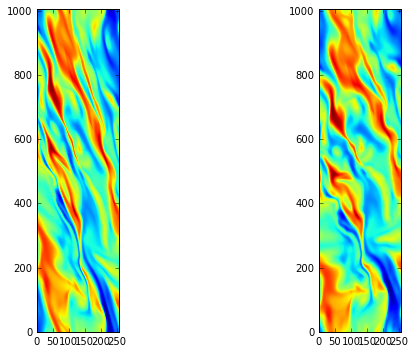

In [3]:
def shear_map(x,dy,qomt,datai,flag=1):
  """ 
  depends on the flag, perform the forward (flag=1) 
  or backward (flag=-1) transfer between shearing
  periodic and exact periodic
  """

  if flag !=1 and flag !=-1:
    print "shear_map: incorrect flag,+1 or -1"
    return 0
  else:
    ndim = datai.ndim
    dim  = np.array(datai.shape)# datai[nz,ny,nx]
    sh_data = np.empty([dim[0],dim[1],dim[2]],dtype='float64')
    tp_data = np.empty([dim[0],dim[1]],dtype='float64')
    sh_y = qomt*x/dy #qshear*omega*dtn*x/dy
    
    for i in np.arange(0,dim[2]):
      quot = int(np.floor(sh_y[i]))
      res  = sh_y[i]-np.float(quot)
      tp_data[:,:] = datai[:,:,i]
      sh_data[:,:,i] = (1.0-res)*np.roll(tp_data,flag*quot,axis=1)\
                +res*np.roll(tp_data,flag*(quot+1),axis=1)
    
    print type(sh_data)
    print sh_data.shape
    return sh_data


qshear, omg = 1.5, 1.0
lx,ly,lz = 2.0,8.0,1.0
nx,ny,nz = 256,1008,128
x = data['x1f']+0.5*(data['x1f'][1]-data['x1f'][0])
x = x[:-1]
dy = data['x2f'][1]-data['x2f'][0]
nt = np.rint(time*qshear*omg*lx/ly)
dtn = time - np.float(nt)*ly/(qshear*omg*lx)
qomt = qshear*omg*dtn
kx = np.roll(np.arange(nx)-nx/2, nx/2)
ky = np.roll(np.arange(ny)-ny/2, ny/2)
kz = np.roll(np.arange(nz)-nz/2, nz/2)
mtp = 1.0 # weight


wrapped = data['Bcc2']
unwrapped =shear_map(x,dy,qomt,wrapped)

matplotlib.rcParams['figure.figsize'] = (10,5)
plt.subplot(1,2,1)
plt.imshow(wrapped[64,:,:],origin='lower')

plt.subplot(1,2,2)
plt.imshow(unwrapped[64,:,:],origin='lower')

plt.tight_layout()

## test the remapping

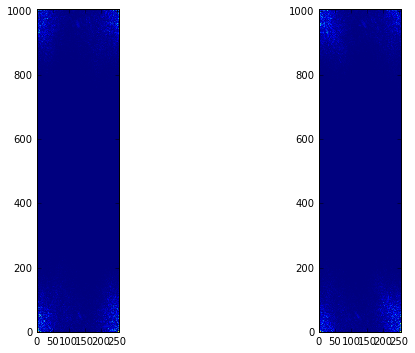

In [39]:
def remap(kx,ky,lx,ly,qomt,datai):
  """
  remap the k-space variable back to shearing 
  periodic frame to reflect the time dependent 
  Eulerian wave number
  """
  ndim = datai.ndim
  dim  = np.array(datai.shape)# datai[nz,ny,nx]
  sh_data = np.empty([dim[0],dim[1],dim[2]])
  tp_data = np.empty([dim[0],dim[2]])
  sh_kx = -qomt*ky*lx/ly
  #nquist= np.max(np.fabs(kx))

  for j in np.arange(0,dim[1]):
    quot = int(np.floor(sh_kx[j]))
    res  = sh_kx[j]-float(quot)
    #kx_new = kx[:] + sh_kx[j]
    tp_data[:,:]= datai[:,j,:]
    sh_data[:,j,:] = (1.0-res)*np.roll(tp_data,quot, axis=1) \
                         + res*np.roll(tp_data,quot+1,axis=1)
    #sh_data[:,j,kx_new[:]>nquist] = 0.0

  return sh_data

from scipy import fftpack 

fft_unwrapped = fftpack.fftn(unwrapped) #np.fft.fftn(unwrapped)
datai = np.real(fft_unwrapped*np.conj(fft_unwrapped))
datao = remap(kx,ky,lx,ly,qomt,datai)

plt.subplot(1,2,1)
plt.imshow(datai[64,:,:],origin='lower')

plt.subplot(1,2,2)
plt.imshow(datao[64,:,:],origin='lower')

plt.tight_layout()

In [41]:
datao.min()

1.4651890895197162e-12

In [24]:
kmod = (np.sqrt((k1/lx)**2+(k2/ly)**2+(k3/lz)**2)+0.5).astype(int)
print kmod.shape
print kmod.max(),kmod.min()

(128, 1008, 256)
110 0


In [27]:
type(min([2,3,4]))

int

## testing the shell int 

In [29]:
def shell_int(kx,ky,kz,lx,ly,lz,datai):
  """
  average the spectra over spherical shells of 
  constant k
  """
  nx = kx.shape[0]; ny = ky.shape[0]; nz = kz.shape[0]
  wcnt = int((min([nx,ny,nz]))/2)+1
  kmod = np.arange(wcnt) 
  power = np.zeros(wcnt)
  k3,k2,k1 = np.meshgrid(kz,ky,kx,indexing='ij')
  kmod3d = (np.sqrt((k1/lx)**2+(k2/ly)**2+(k3/lz)**2)+0.5).astype(int)
  for i in xrange(0,wcnt):
    power[i] = np.sum(datai[np.where(kmod3d == kmod[i])])
  
  return kmod,power

kmod,power = shell_int(kx,ky,kz,lx,ly,lz,datao)

/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power


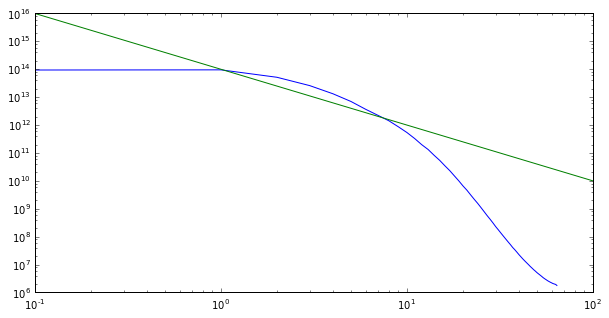

In [38]:
plt.plot(kmod,power)
plt.xscale('log')
plt.yscale('log')
amp = 1e14
plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-5/3))

## pwrspec of B^2

In [3]:
#from astropy.table import Table, Column, MaskedColumn
#from astropy.io import ascii

#atable = ascii.read('/scr/depot0/jmshi/Unstra-1b.00080.pwr')
dirname = '/tigress/jiming/reconnect/athena/bin/'
targname = 'x2y8z1r128pm0.5re3000/'
fname = dirname+targname+'/'+'Unstra-1b.00051.pwr'
ahist = np.loadtxt(fname, skiprows=1)

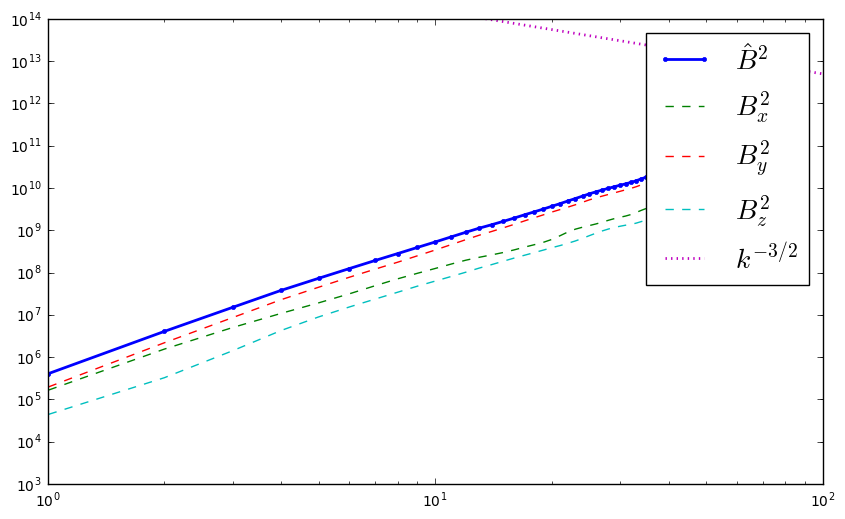

In [5]:
matplotlib.rcParams['figure.figsize'] = (10,6)

plt.plot(ahist[:,0],ahist[:,1]*ahist[:,0]**2,'.-',lw=2,label=r'$\hat B^2$')
plt.plot(ahist[:,0],ahist[:,2]*ahist[:,0]**2,'--',label=r'$B_x^2$')
plt.plot(ahist[:,0],ahist[:,3]*ahist[:,0]**2,'--',label=r'$B_y^2$')
plt.plot(ahist[:,0],ahist[:,4]*ahist[:,0]**2,'--',label=r'$B_z^2$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,100])
plt.ylim([1e3,1e14])
amp = 5e15
plt.plot(np.arange(0,100,0.1),amp*np.arange(0.01,100,0.1)**(-1.5),':',lw=2,label=r'$k^{-3/2}$')
#plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-1),':',lw=2)
#plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-2),':',lw=2)
plt.legend(fontsize=20)

## energy spectra of $B^2$ and $E_k$
as Pm = 0.5, $E_k$ dominates at smaller scale (larger k)

what is the roll-over part at the high k end??

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.]


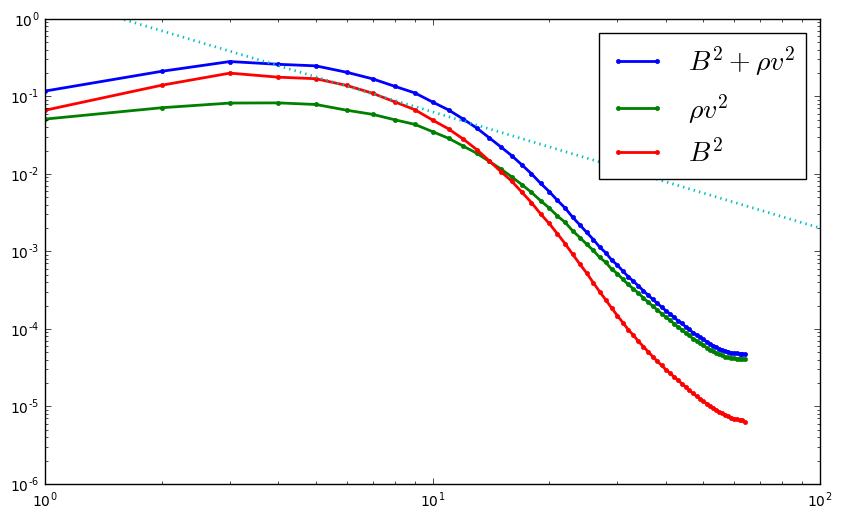

In [11]:
bhist = 0; ahist = 0
dirname = '/tigress/jiming/reconnect/athena/bin/'
targname = 'x2y4z1r128pm0.5re3000' #x2y8z1r128pm0.5re3000/'

for i in np.arange(50,100,10):
  bhist += np.loadtxt(dirname+targname+'/'+'Unstra-1b.'+str(i).zfill(5)+'.pwr', skiprows=1)
  ahist += np.loadtxt(dirname+targname+'/'+'Unstra-1v.'+str(i).zfill(5)+'.pwr', skiprows=1)
   
ahist /= 5.0
bhist /= 5.0
print ahist[:,0]
matplotlib.rcParams['figure.figsize'] = (10,6)

fnorm = float(256*256*2*128)
plt.plot(ahist[:,0],(ahist[:,1]+bhist[:,1])*ahist[:,0]**2/fnorm**2,'.-',lw=2,label=r'$B^2+\rho v^2$')
plt.plot(ahist[:,0],ahist[:,1]*ahist[:,0]**2/fnorm**2,'.-',lw=2,label=r'$\rho v^2$')
#plt.plot(ahist[:,0],ahist[:,2]*ahist[:,0]**2,'.-',lw=2,label=r'$\rho v_x^2$')
#plt.plot(ahist[:,0],ahist[:,3]*ahist[:,0]**2,'.-',lw=2,label=r'$\rho v_y^2$')
#plt.plot(ahist[:,0],ahist[:,4]*ahist[:,0]**2,'.-',lw=2,label=r'$\rho v_z^2$')
plt.plot(ahist[:,0],bhist[:,1]*bhist[:,0]**2/fnorm**2,'.-',lw=2,label=r'$B^2$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,100])
plt.ylim([1e-6,1])
amp = 2
plt.plot(np.arange(0,100,0.1),amp*np.arange(0.01,100,0.1)**(-1.5),':',lw=2)
#plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-1),':',lw=2)
#plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-2),':',lw=2)
plt.legend(fontsize=20)

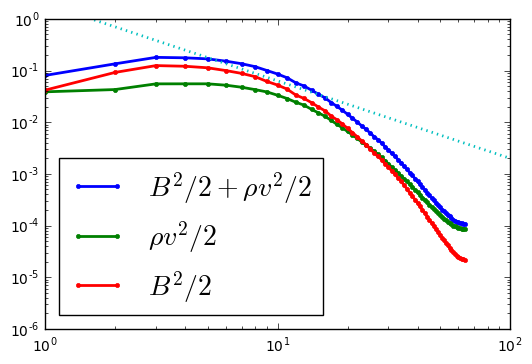

In [2]:
from pspec import plot_pspec1d

targname = 'x2y8z1r128pm0.5re3000'
plot_pspec1d(targname)

In [12]:
import matplotlib
import matplotlib.pyplot as plt


def plot_pspec1d(targname,ts=50,te=100,stride=10):

  dirname = '/tigress/jiming/reconnect/athena/bin/'
  #targname = 'x2y4z1r128pm0.5re3000' #x2y8z1r128pm0.5re3000/'
  ncells = 256*256*4*128# default 2x8x1 with 128/H
  if targname[0:6] == 'x2y4z1':
    ncells /=2
  if targname[6:9] == 'r64':
    ncells /=8
  else:
    resol = int(targname[7:10])
    ncells = ncells * (resol/128)**3
  if targname[10:12] == 'ry':
    yresol = int(targname[12:14])
    ncells = int(ncells*yresol/128)
  print ncells
  fnorm = float(ncells)**2*2.0 # extra factor of 1/2 for B^2/2 and rho v^2/2
  bhist = 0; ahist = 0; cnt = 0
  for i in np.arange(ts,te,stride):
    bhist += np.loadtxt(dirname+targname+'/'+'Unstra-1b.'+str(i).zfill(5)+'.pwr', skiprows=1)
    ahist += np.loadtxt(dirname+targname+'/'+'Unstra-1v.'+str(i).zfill(5)+'.pwr', skiprows=1)
    cnt += 1 
  ahist /= float(cnt)
  bhist /= float(cnt)
  #matplotlib.rcParams['figure.figsize'] = (10,6)
  plt.plot(ahist[:,0],(ahist[:,1]+bhist[:,1])*ahist[:,0]**2/fnorm,'.-',lw=2,label=r'$B^2/2+\rho v^2/2$')
  plt.plot(ahist[:,0],ahist[:,1]*ahist[:,0]**2/fnorm,'.-',lw=2,label=r'$\rho v^2/2$')
  #plt.plot(ahist[:,0],ahist[:,2]*ahist[:,0]**2/fnorm,'.-',lw=2,label=r'$\rho v_x^2$')
  #plt.plot(ahist[:,0],ahist[:,3]*ahist[:,0]**2/fnorm,'.-',lw=2,label=r'$\rho v_y^2$')
  #plt.plot(ahist[:,0],ahist[:,4]*ahist[:,0]**2/fnorm,'.-',lw=2,label=r'$\rho v_z^2$')
  plt.plot(ahist[:,0],bhist[:,1]*bhist[:,0]**2/fnorm,'.-',lw=2,label=r'$B^2/2$')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim([1,100])
  plt.ylim([1e-6,1])
  amp = 2
  plt.plot(np.arange(0,100,0.1),amp*np.arange(0.01,100,0.1)**(-1.5),':',lw=2)
  #plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-1),':',lw=2)
  #plt.plot(np.arange(0,100,0.1),amp*np.arange(0,100,0.1)**(-2),':',lw=2)
  plt.legend(fontsize=20,loc=3)


8388608


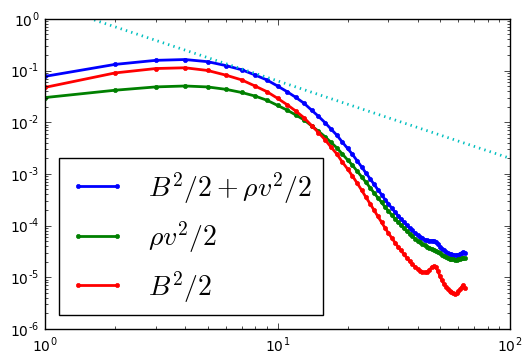

In [13]:
targname = 'x2y4z1r128ry64pm0.5re3000'
plot_pspec1d(targname)

In [2]:
fname = 'Unstra.out2.00050.athdf'
time, data = ath.athdf(fname)

KeyboardInterrupt: 

## Test the script against Shane's c-code 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
import athena4_read as ath4
import pspec 
from astropy.table import Table, Column, MaskedColumn
from astropy.io import ascii
import sys
import os

In [2]:
dirname = '/home/jiming/reconnect/py'
targname = ''
i=80
fname = dirname+targname+'/'+'Unstra.'+str(i).zfill(4)+'.vtk'
time, x,y,z,data = ath4.vtk(fname)

time =  2481.862
face_dimensions =  [65, 257, 257]
-5.000000e-01 -2.000000e+00 -2.000000e+00
box_origin =  [-0.5, -2.0, -2.0]
1.562500e-02 1.562500e-02 1.562500e-02
grid_spacing =  [0.015625, 0.015625, 0.015625]
cell_dimensions =  [256 256  64]  num_cells =  4194304
SCALARS
start loading scalars !! 
loading array_name =  density
is,ie =  297 16777513
data[density].shape=  (256, 256, 64)
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  momentum
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  cell_centered_B


In [15]:
data['density'].shape

(256, 256, 64)

In [14]:

omg=1;qshear=1.5
# get the grid info
dx = x[1]-x[0]
dy = y[1]-y[0]
dz = z[1]-z[0]
nx = len(x)
ny = len(y)
nz = len(z)
lx,ly,lz = 1,4,4
kx = np.roll(np.arange(nx)-nx/2+1, nx/2+1)
ky = np.roll(np.arange(ny)-ny/2+1, ny/2+1)
kz = np.roll(np.arange(nz)-nz/2+1, nz/2+1)
#kx = np.arange(nx)
#ky = np.arange(ny)-ny
#kz = np.arange(nz)-nz
# calculate the shear amount
nt = np.rint(time*qshear*omg*lx/ly)
dtn = time - np.float64(nt)*ly/(qshear*omg*lx)
qomt = qshear*omg*dtn

print 'analyze '+fname+': '
mtp = 1.0 #1.0/np.sqrt(data['density']) # weight

print 'calc pwrspec of Bcc1'
#kmod,pwr1 = powerspectra(data['Bcc1'],x,dy,kx,ky,kz,lx,ly,lz,qomt,mtp)
kmod,kmodx,kmody,kmodz,pwr1,pwr1x,pwr1y,pwr1z = pspec.powerspectra(data['cell_centered_B'][...,0],x,dy,kx,ky,kz,lx,ly,lz,qomt,mtp)

print 'calc pwrspec of Bcc2'
#kmod,pwr2 = powerspectra(data['Bcc2'],x,dy,kx,ky,kz,lx,ly,lz,qomt,mtp)
kmod,kmodx,kmody,kmodz,pwr2,pwr2x,pwr2y,pwr2z = pspec.powerspectra(data['cell_centered_B'][...,1],x,dy,kx,ky,kz,lx,ly,lz,qomt,mtp)

print 'calc pwrspec of Bcc3'
#kmod,pwr3 = powerspectra(data['Bcc3'],x,dy,kx,ky,kz,lx,ly,lz,qomt,mtp)
kmod,kmodx,kmody,kmodz,pwr3,pwr3x,pwr3y,pwr3z = pspec.powerspectra(data['cell_centered_B'][...,2],x,dy,kx,ky,kz,lx,ly,lz,qomt,mtp)
## the convention here is: 1,2,3 for B-component; x,y,z for k-axis
pwr  = pwr1 + pwr2 + pwr3
pwrx  = pwr1x + pwr2x + pwr3x 
pwry  = pwr1y + pwr2y + pwr3y
pwrz  = pwr1z + pwr2z + pwr3z

i=80
dumpname = dirname+targname+'/'+'Unstra-spec1b.'+str(i).zfill(5)+'.pwr'
dumpdata = Table([kmod,pwr,pwr1,pwr2,pwr3],names=['kmod','pwr','pwr1','pwr2','pwr3'])
dumpdata.write(dumpname,format='ascii')

dumpdata = Table([kmodx,pwrx,pwr1x,pwr2x,pwr3x],names=['kmodx','pwrx','pwr1x','pwr2x','pwr3x'])
with open(dumpname,mode='a') as f:
  f.seek(0,os.SEEK_END)
  dumpdata.write(f,format='ascii')
  dumpdata = Table([kmody,pwry,pwr1y,pwr2y,pwr3y],names=['kmody','pwry','pwr1y','pwr2y','pwr3y'])
  f.seek(0,os.SEEK_END)
  dumpdata.write(f,format='ascii')
  dumpdata = Table([kmodz,pwrz,pwr1z,pwr2z,pwr3z],names=['kmodz','pwrz','pwr1z','pwr2z','pwr3z'])
  f.seek(0,os.SEEK_END)
  dumpdata.write(f,format='ascii')

print 'dumped pwrspec to '+dumpname




analyze /home/jiming/reconnect/py/Unstra-spec1b.00080.pwr: 
calc pwrspec of Bcc1
calc pwrspec of Bcc2
calc pwrspec of Bcc3
dumped pwrspec to /home/jiming/reconnect/py/Unstra-spec1b.00080.pwr


In [15]:
import pandas as pd
ncells = nx*ny*nz
fnorm = float(ncells)**2*2.0 # extra factor of 1/2 for B^2/2 and rho v^2/2
bhist = 0; ahist = 0
bkxhist = 0; akxhist = 0
bkyhist = 0; akyhist = 0
bkzhist = 0; akzhist = 0
nkx,nky,nkz = nx/2,ny/2,nz/2
nk = np.min([nx/2,ny/2,nz/2])

fname = dirname+targname+'/'+'Unstra-spec1b.'+str(80).zfill(5)+'.pwr'
df = pd.read_table(fname,delimiter=' ',skiprows=1,nrows=nk+1,header=None)
bhist += df.values
df = pd.read_table(fname,delimiter=' ',skiprows=1+nk+2,nrows=nkx+1,header=None)
bkxhist += df.values
df = pd.read_table(fname,delimiter=' ',skiprows=1+nk+nkx+4,nrows=nky+1,header=None)
bkyhist += df.values
df = pd.read_table(fname,delimiter=' ',skiprows=1+nk+nkx+nky+6,nrows=nkz+1,header=None)
bkzhist += df.values


for i in np.arange(4):
  if i == 0:
    fn = 1.0
  else:
    fn = fnorm
  bhist[:,i] /= fn;bkxhist[:,i] /= fn;bkyhist[:,i] /= fn; bkzhist[:,i] /=fn 

kmod,kmodx,kmody,kmodz,pwrb,pwrbx,pwrby,pwrbz = \
bhist[:,0],bkxhist[:,0],bkyhist[:,0],bkzhist[:,0],\
bhist[:,1]*bhist[:,0]**2,\
bkxhist[:,1]*bkxhist[:,0],\
bkyhist[:,1]*bkyhist[:,0],\
bkzhist[:,1]*bkzhist[:,0]

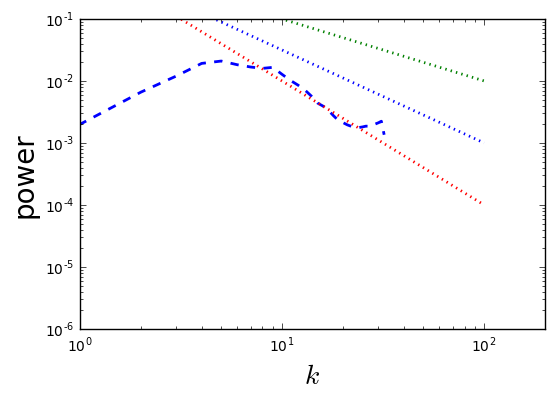

In [16]:
clist = ['b','g','r','k','y']
cnt = 0

#plt.plot(k,pwra,'-'+clist[cnt],lw=2,label=targname+': '+r'$\rho v^2/2$')
plt.plot(kmod,pwrb,'--'+clist[cnt],lw=2,label=targname+': '+r'$B^2/2$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1,200])
plt.ylim([1e-6,0.1])
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel('power',fontsize=20)
amp = 1
plt.plot(np.arange(0,100,0.1),amp*np.arange(0.01,100,0.1)**(-1.5),':',lw=2)
plt.plot(np.arange(0,100,0.1),amp*np.arange(0.01,100,0.1)**(-1),':',lw=2)
plt.plot(np.arange(0,100,0.1),amp*np.arange(0.01,100,0.1)**(-2),':',lw=2)
#plt.legend(fontsize=15,loc=0)

In [11]:
k3,k2,k1 = np.meshgrid(kz,ky,kx,indexing='ij')

In [17]:
kx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32, -31, -30, -29, -28, -27, -26,
       -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1])